In [ ]:
# Step 1: Upload and Extract Dataset
from google.colab import files
uploaded = files.upload()

import zipfile, os

zip_path = "/content/archive (1).zip"  # Replace if your file name is different
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.listdir(extract_path)

# Set paths
train_dir = "/content/dataset/covid_update/Train"
test_dir = "/content/dataset/covid_update/Test"


Saving archive (1).zip to archive (1).zip


In [ ]:
# Step 2: Data Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=20,
    horizontal_flip=True
)

test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='binary'
)

test_data = test_gen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='binary', shuffle=False
)


Found 453 images belonging to 2 classes.
Found 219 images belonging to 2 classes.


In [ ]:
import os

def count_images(directory):
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path):
            print(f"{cls} - {len(os.listdir(cls_path))} images")

print("Train:")
count_images(train_dir)

print("\nTest:")
count_images(test_dir)


Train:
non_covid - 203 images
covid - 250 images

Test:
non_covid - 119 images
covid - 100 images


In [ ]:
# Step 3: Load DenseNet121 with Custom Head
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = list(train_data.class_indices.keys())
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)


Class Weights: {0: np.float64(0.906), 1: np.float64(1.1157635467980296)}


In [ ]:
# Unfreeze last 100 layers for fine-tuning
for layer in base_model.layers[-100:]:
    layer.trainable = True


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower LR for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=5, restore_best_weights=True)


In [ ]:
history_fine = model.fit(
    train_data,
    epochs=30,
    validation_data=test_data,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.5231 - loss: 0.7919 - val_accuracy: 0.5799 - val_loss: 0.6299
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 874ms/step - accuracy: 0.6318 - loss: 0.6813 - val_accuracy: 0.5845 - val_loss: 0.6334
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 751ms/step - accuracy: 0.6283 - loss: 0.6306 - val_accuracy: 0.5799 - val_loss: 0.6347
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 724ms/step - accuracy: 0.6672 - loss: 0.6129 - val_accuracy: 0.5845 - val_loss: 0.6338
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 737ms/step - accuracy: 0.6777 - loss: 0.5780 - val_accuracy: 0.5982 - val_loss: 0.6279
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 761ms/step - accuracy: 0.7707 - loss: 0.4560 - val_accuracy: 0.6073 - val_loss: 0.6188
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 777ms/step - accuracy: 0.7981 - loss: 0.4334 - val_accuracy: 0.6119 - val_loss: 0.6074
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 773ms/step - accuracy: 0.8205 - loss: 0.3944 - val_accurac

In [ ]:
# STEP 6: EVALUATE AND PRINT ACCURACY
loss, acc = model.evaluate(test_data)
print(f"\n✅ Final Test Accuracy: {acc * 100:.2f}%")


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 463ms/step - accuracy: 0.7482 - loss: 0.5218

✅ Final Test Accuracy: 82.65%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
pred_probs = model.predict(test_data)
preds = (pred_probs > 0.5).astype(int).flatten()
true_labels = test_data.classes

# Report
print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, preds))

print("\nClassification Report:")
print(classification_report(true_labels, preds, target_names=classes))


7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step

Confusion Matrix:
[[ 64  36]
 [  2 117]]

Classification Report:
              precision    recall  f1-score   support

       covid       0.97      0.64      0.77       100
   non_covid       0.76      0.98      0.86       119

    accuracy                           0.83       219
   macro avg       0.87      0.81      0.82       219
weighted avg       0.86      0.83      0.82       219



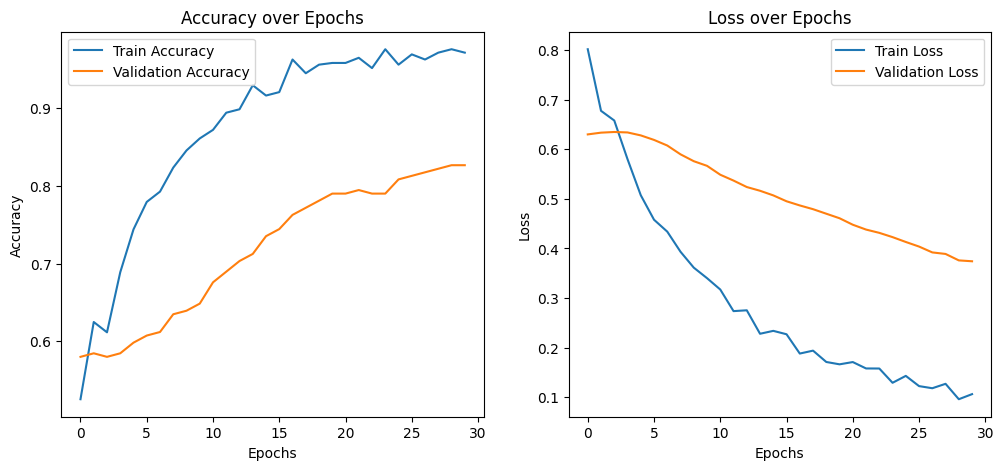

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_fine.history['loss'], label='Train Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Predict probabilities on test data
y_pred_prob = model.predict(test_data)

# Step 2: Convert probabilities to binary predictions (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Step 3: Get true labels from the test generator
y_true = test_data.classes

# Step 4: Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Step 5: Print results
print(f"\n📊 Evaluation Metrics on Test Set:")
print(f"✅ Accuracy : {accuracy * 100:.2f}%")
print(f"🎯 Precision: {precision * 100:.2f}%")
print(f"📥 Recall   : {recall * 100:.2f}%")
print(f"📈 F1 Score : {f1 * 100:.2f}%")


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 525ms/step

📊 Evaluation Metrics on Test Set:
✅ Accuracy : 82.65%
🎯 Precision: 76.47%
📥 Recall   : 98.32%
📈 F1 Score : 86.03%


<Figure size 600x600 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


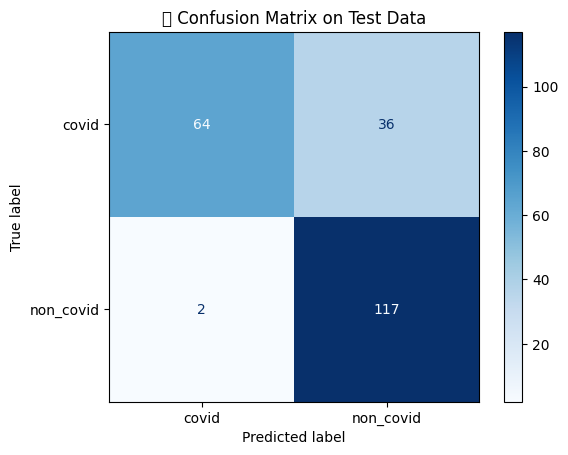

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 2: Create display object (with class labels)
class_names = list(test_data.class_indices.keys())  # e.g., ['COVID', 'Normal']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Step 3: Plot
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("🧪 Confusion Matrix on Test Data")
plt.grid(False)
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 371ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


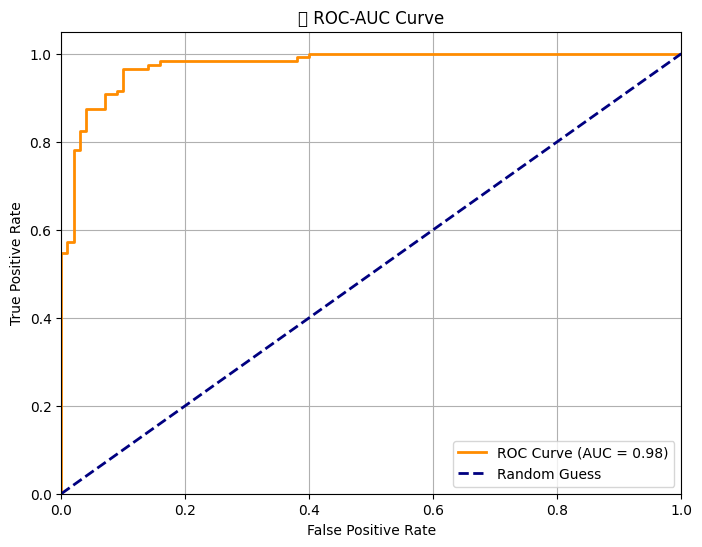

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Get ground truth labels and prediction probabilities
y_true = test_data.classes
y_prob = model.predict(test_data).ravel()  # Flatten to 1D

# Step 2: Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# Step 3: Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📈 ROC-AUC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Saving yes covid.jpg to yes covid.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


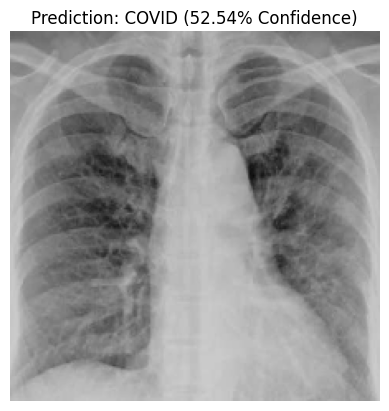

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Step 1: Upload Image
uploaded = files.upload()

# Step 2: Load and Preprocess the Image
for fn in uploaded.keys():
    img_path = fn
    img = image.load_img(img_path, target_size=(224, 224))  # Same as training size
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Batch dimension

    # Step 3: Make Prediction
    prediction = model.predict(img_array)[0][0]

    # Step 4: Interpret and Display
    label = "COVID" if prediction > 0.5 else "Normal"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {label} ({confidence*100:.2f}% Confidence)")
    plt.show()


In [ ]:
# Save the model in HDF5 format
model.save("covid_densenet121_model.h5")


In [ ]:
from google.colab import files
files.download("covid_densenet121_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>